In [1648]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import cv2 
import os
import math
import json

In [1649]:
def normalize(tensor: torch.Tensor) -> torch.Tensor:
    return (tensor - tensor.min()) / (tensor.max() - tensor.min())
def process_tensor(tensor : torch.Tensor) -> np.array:
    if len(tensor.shape) == 3 and tensor.shape[0] == 3:
        tensor = tensor.permute(1, 2, 0).detach().cpu()
        tensor = tensor.numpy()
        # tensor[:, :, [0, 2]] = tensor[:, :, [2, 0]]
    elif len(tensor.shape) == 3 and tensor.shape[0] == 1:
        tensor = tensor[0].detach().cpu().squeeze()
        tensor = tensor.numpy()
    elif len(tensor.shape) == 2:
        tensor = tensor.detach().cpu().squeeze()
        tensor = tensor.numpy()
    return tensor
    

In [1650]:
debug_tensor_path = "./debug_tensor"
debug_tensor_map : dict = {}
for filename in os.listdir(debug_tensor_path):
    if not filename.endswith(".pt"):
        continue
    debug_tensor_map[filename] = torch.load(os.path.join(debug_tensor_path, filename))

In [1651]:
processed_img : dict = {}
for key in debug_tensor_map:
    processed_img[key] = process_tensor(debug_tensor_map[key])
    print(f"{key}: {processed_img[key].shape}")

rendered_normal.pt: (552, 982, 3)
normal.pt: (552, 982, 3)
plane_depth.pt: (552, 982)
depth_metric.pt: (552, 982)
render.pt: (552, 982, 3)
depth_normal.pt: (552, 982, 3)


{'normal_loss': 0.003171628573909402, 'depth_loss': 0.004122920334339142}


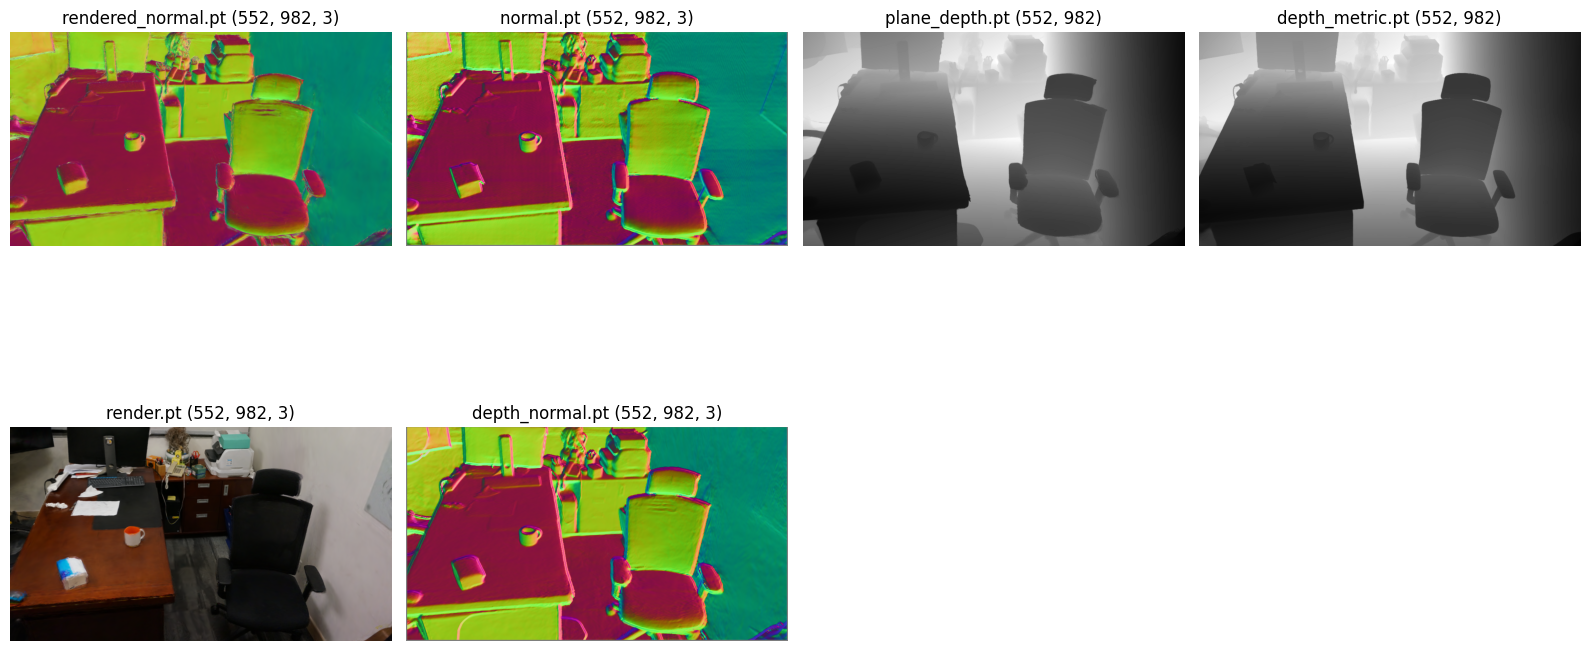

In [1652]:
num_images = len(processed_img)
cols = math.ceil(math.sqrt(num_images)) + 1  # 每行的列数
rows = math.ceil(num_images / cols) + 1
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
for i, image_key in enumerate(processed_img):
    row = i // cols
    col = i % cols
    image = processed_img[image_key]
    if len(image.shape) == 3 and image.shape[2] == 3:
        axes[row, col].imshow(normalize(image))  # 彩色图片不需要cmap
    else:
        axes[row, col].imshow(image, cmap='gray')  # 黑白图片使用'gray' cmap

    axes[row, col].set_title(image_key + f" {image.shape}")
    axes[row, col].axis('off')  # 隐藏坐标轴

for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])  # 删除空白的子图
    

with open(os.path.join(debug_tensor_path, 'loss.json'), 'r', encoding='utf-8') as file:
    data = json.load(file)

# 输出 JSON 文件内容
print(data)


plt.tight_layout()
plt.show()

[ 1.5624471e-04 -8.6036777e-01 -5.0967366e-01]


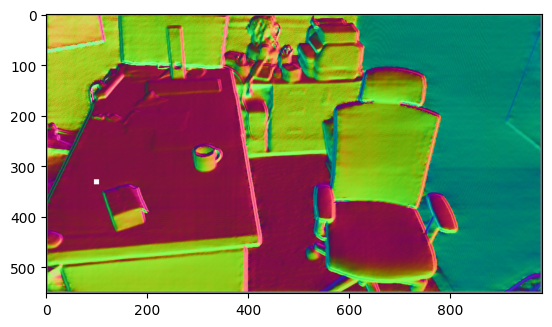

: 

In [ ]:
point = (-220, 100)
normal = processed_img["normal.pt"].copy()
print(normal[point[0], point[1]])
normal[point[0] - 5 : point[0] + 5, point[1] - 5 : point[1] + 5, :] = 1
plt.imshow(normalize(normal))